In [8]:
import pandas as pd
import numpy as np
from econml.metalearners import XLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from sklearn.utils import resample
from scipy.stats import t

In [2]:
# Load data from CSV files
data = pd.read_csv("/path/to/your/directory/N.2012_ONLY.csv")
income_df = pd.read_csv("/path/to/your/directory/N.covariates.csv", low_memory=False)

# Drop unnecessary columns
data.drop(['hid_x', 'health'], axis=1, inplace=True)

In [5]:
# CATE ESTIMATES for Income- RESULTS IN % of BASELINE INCOME

# Filtering the 2011 data from the main dataframe
data_2011 = data[data['syear'] == 2011]

# Defining the years to calculate the CATE for
years = range(2013, 2021)

# Storing results for each year
cate_results = {}
cate_results_scaled = {}

# Calculate the baseline mean income for 2011
baseline_mean_income = data_2011['gross_income'].mean()

# Loop through each year
for year in years:
    # Filter the income data for the given year
    income_year = income_df[income_df['syear'] == year][['pid', 'gross_income']]
    
    # Merge the income data with the 2011 data based on 'pid'
    merged_data = pd.merge(data_2011, income_year, on='pid', how='inner', suffixes=('_2011', f'_{year}'))
    
    # Drop rows with any missing values
    merged_data_clean = merged_data.dropna(subset=['sex', 'age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status', 'binary_treatment', f'gross_income_{year}'])
    
    # Define covariates, treatment, and outcome
    X_clean = merged_data_clean[['sex', 'age_at_survey', 'education', 'hhgr', 'gross_income_2011', 'lf_status']]
    T_clean = merged_data_clean['binary_treatment']
    y_clean = merged_data_clean[f'gross_income_{year}']

    # Define the models for the outcome and propensity score estimation
    outcome_learner = GradientBoostingRegressor(n_estimators=100, random_state=42)
    propensity_learner = LogisticRegression(random_state=42, max_iter=1000)
    
    # Instantiate the X-Learner
    x_learner = XLearner(models=outcome_learner, propensity_model=propensity_learner)
    
    # Fit the X-Learner
    x_learner.fit(y_clean, T_clean, X=X_clean)
    
    # Estimate the Conditional Average Treatment Effect (CATE) for the entire dataset
    cate_estimates = x_learner.effect(X_clean)
    
    # Scale the CATE estimates by the baseline mean income
    cate_estimates_scaled = cate_estimates / baseline_mean_income
    
    # Store the results
    cate_results[year] = cate_estimates
    cate_results_scaled[year] = cate_estimates_scaled

    # # Print scaled CATE estimates for the year
    # print(f"Scaled CATE Estimates for {year}:")
    # print(cate_estimates_scaled)

    # a function for bootstrapping
    def bootstrap_cate(X, T, y, x_learner):
        X_resampled, T_resampled, y_resampled = resample(X, T, y)
        x_learner.fit(y_resampled, T_resampled, X=X_resampled)
        return np.mean(x_learner.effect(X_resampled))

    # Parallel bootstrapping
    n_bootstraps = 200  # Adjust this as needed
    bootstrapped_cates = Parallel(n_jobs=-1)(delayed(bootstrap_cate)(X_clean, T_clean, y_clean, x_learner) for _ in range(n_bootstraps))

    # Calculating confidence intervals and standard error for scaled estimates
    ci_lower = np.percentile(bootstrapped_cates, 2.5) / baseline_mean_income
    ci_upper = np.percentile(bootstrapped_cates, 97.5) / baseline_mean_income
    std_error = np.std(bootstrapped_cates) / baseline_mean_income

    # print(f"95% Confidence Interval for {year}: [{ci_lower}, {ci_upper}]")
    # print(f"Standard Error for {year}: {std_error}")

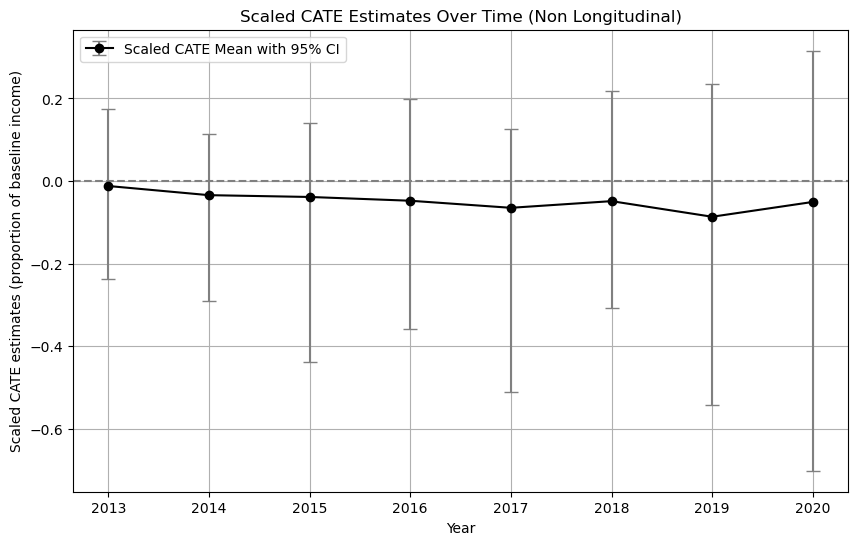

In [6]:
# Converting years to a list
years = list(cate_results_scaled.keys())

# Calculating the mean of the scaled CATE estimates for each year
mean_cates_scaled = [np.mean(cate_results_scaled[year]) for year in years]

# Calculate the confidence intervals for each year
ci_lowers = []
ci_uppers = []
for year in years:
    bootstrapped_cates = cate_results_scaled[year]
    ci_lower = np.percentile(bootstrapped_cates, 2.5)
    ci_upper = np.percentile(bootstrapped_cates, 97.5)
    ci_lowers.append(ci_lower)
    ci_uppers.append(ci_upper)

# Convert lists to numpy arrays for easy calculation of error bars
years = np.array(years)
mean_cates_scaled = np.array(mean_cates_scaled)
ci_lowers = np.array(ci_lowers)
ci_uppers = np.array(ci_uppers)

# Calculating the error margins
error_bars = [mean_cates_scaled - ci_lowers, ci_uppers - mean_cates_scaled]

# Plotting the results with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(years, mean_cates_scaled, yerr=error_bars, fmt='o-', color='black', ecolor='gray', capsize=5, label='Scaled CATE Mean with 95% CI')
plt.axhline(0, color='gray', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Scaled CATE estimates (proportion of baseline income)')
plt.title('Scaled CATE Estimates Over Time (Non Longitudinal)')
plt.xticks(years)
plt.grid(True)
plt.legend()
plt.show()


In [7]:
# calculating the mean scaled/normalised CATE estimates for each year

# Calculate the mean of the scaled CATE estimates for each year
mean_cates_scaled = {year: np.mean(cate_results_scaled[year]) for year in cate_results_scaled}

# Display 
for year, mean_cate in mean_cates_scaled.items():
    print(f"Year {year}: Scaled Mean CATE Estimate = {mean_cate:.4f}")

Year 2013: Scaled Mean CATE Estimate = -0.0120
Year 2014: Scaled Mean CATE Estimate = -0.0342
Year 2015: Scaled Mean CATE Estimate = -0.0385
Year 2016: Scaled Mean CATE Estimate = -0.0477
Year 2017: Scaled Mean CATE Estimate = -0.0648
Year 2018: Scaled Mean CATE Estimate = -0.0486
Year 2019: Scaled Mean CATE Estimate = -0.0864
Year 2020: Scaled Mean CATE Estimate = -0.0506


In [9]:
# calculating the t-values and p-values for each year
# Lists to store t-values and p-values
t_values = []
p_values = []

# Loop through each year
for year in years:
    print(f"Calculating t-value and p-value for year {year}...")

    # Calculating the mean of the scaled CATE estimates for the year
    mean_cate_scaled = np.mean(cate_results_scaled[year])
    
    # Calculate the t-value
    t_value = mean_cate_scaled / std_error  # Use the standard error from the bootstrapping
    t_values.append(t_value)
    
    # Calculate the p-value using the t-distribution
    df = len(cate_results_scaled[year]) - 1  # degrees of freedom
    p_value = 2 * (1 - t.cdf(abs(t_value), df=df))
    p_values.append(p_value)
    
    print(f"Year {year}:")
    print(f"  t-value: {t_value}")
    print(f"  p-value: {p_value}")


Calculating t-value and p-value for year 2013...
Year 2013:
  t-value: -0.4359040272675756
  p-value: 0.6629222811206503
Calculating t-value and p-value for year 2014...
Year 2014:
  t-value: -1.241211603485995
  p-value: 0.21458350269663296
Calculating t-value and p-value for year 2015...
Year 2015:
  t-value: -1.399340151091863
  p-value: 0.161776261691029
Calculating t-value and p-value for year 2016...
Year 2016:
  t-value: -1.7309184201670997
  p-value: 0.08353825165361872
Calculating t-value and p-value for year 2017...
Year 2017:
  t-value: -2.3518908071148195
  p-value: 0.0187269723975636
Calculating t-value and p-value for year 2018...
Year 2018:
  t-value: -1.7667464294845916
  p-value: 0.07735618637879349
Calculating t-value and p-value for year 2019...
Year 2019:
  t-value: -3.138426792713633
  p-value: 0.0017141087102245933
Calculating t-value and p-value for year 2020...
Year 2020:
  t-value: -1.8369603555144698
  p-value: 0.06631798995443838


In [10]:
# CATE ESTIMATES for Working Hours- RESULTS IN % of BASELINE WORKING HOURS

# Define the years for CATE estimation
years = range(2013, 2021)

# StorING results for each year
cate_results_wh_nl = {}
cate_results_scaled_wh_nl = {}

# Calculate the baseline mean HOURS for 2011
baseline_mean_hours = data_2011['working_hours'].mean()

# Loop through each year
for year in years:
    # Filter the income data for the given year
    income_year = income_df[income_df['syear'] == year][['pid', 'working_hours']]
    
    # Merge the income data with the 2011 data based on 'pid'
    merged_data = pd.merge(data_2011, income_year, on='pid', how='inner', suffixes=('_2011', f'_{year}'))
    
    # Drop rows with any missing values
    merged_data_clean = merged_data.dropna(subset=['sex', 'age_at_survey', 'education', 'hhgr', 'working_hours_2011', 'gross_income', 'lf_status', 'binary_treatment', f'working_hours_{year}'])
    
    # Define covariates, treatment, and outcome
    X_clean = merged_data_clean[['sex', 'age_at_survey', 'education', 'hhgr', 'gross_income', 'lf_status', 'working_hours_2011']]
    T_clean = merged_data_clean['binary_treatment']
    y_clean = merged_data_clean[f'working_hours_{year}']

    # Define the models for the outcome and propensity score estimation
    outcome_learner = GradientBoostingRegressor(n_estimators=100, random_state=42)
    propensity_learner = LogisticRegression(random_state=42, max_iter=1000)
    
    # Instantiate the X-Learner
    x_learner = XLearner(models=outcome_learner, propensity_model=propensity_learner)
    
    # Fit the X-Learner
    x_learner.fit(y_clean, T_clean, X=X_clean)
    
    # Estimate the Conditional Average Treatment Effect (CATE) for the entire dataset
    cate_estimates_wh_nl = x_learner.effect(X_clean)
    
    # Scale the CATE estimates by the baseline mean income
    cate_estimates_scaled_wh_nl = cate_estimates_wh_nl / baseline_mean_hours
    
    # Store the results
    cate_results_wh_nl[year] = cate_estimates_wh_nl
    cate_results_scaled_wh_nl[year] = cate_estimates_scaled_wh_nl

    # Print scaled CATE estimates for the year
    # print(f"Scaled CATE Estimates for {year}:")
    # print(cate_estimates_scaled_wh_nl)

    # Defining a function for bootstrapping
    def bootstrap_cate(X, T, y, x_learner):
        X_resampled, T_resampled, y_resampled = resample(X, T, y)
        x_learner.fit(y_resampled, T_resampled, X=X_resampled)
        return np.mean(x_learner.effect(X_resampled))

    # Parallel bootstrapping
    n_bootstraps = 200  # Adjust this as needed
    bootstrapped_cates = Parallel(n_jobs=-1)(delayed(bootstrap_cate)(X_clean, T_clean, y_clean, x_learner) for _ in range(n_bootstraps))

    # Calculating confidence intervals and standard error 
    ci_lower = np.percentile(bootstrapped_cates, 2.5) / baseline_mean_hours
    ci_upper = np.percentile(bootstrapped_cates, 97.5) / baseline_mean_hours
    std_error = np.std(bootstrapped_cates) / baseline_mean_hours

    # print(f"95% Confidence Interval for {year}: [{ci_lower}, {ci_upper}]")
    # print(f"Standard Error for {year}: {std_error}")


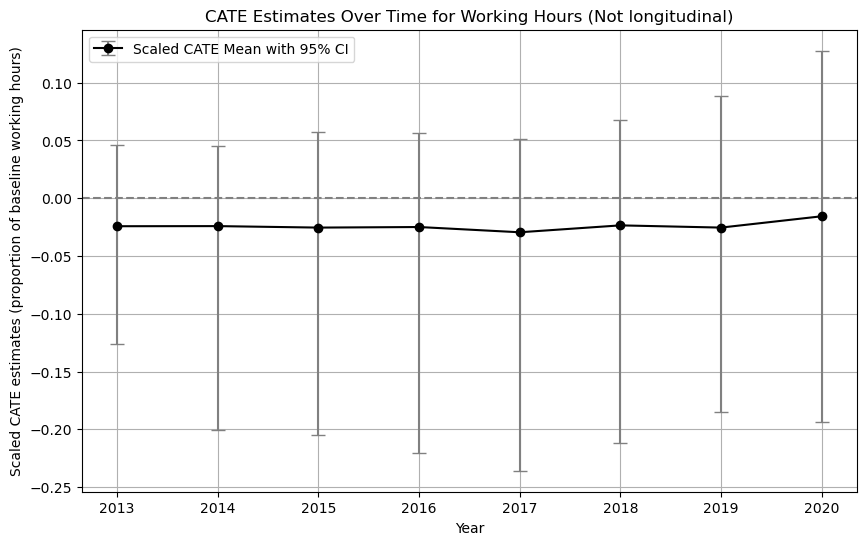

In [11]:
# plotting the results of working hours estimates with error bars
# Converting years to a list
years = list(cate_results_scaled_wh_nl.keys())

# Calculate the mean of the scaled CATE estimates for each year
mean_cates_scaled_wh_nl = [np.mean(cate_results_scaled_wh_nl[year]) for year in years]

# Calculate the confidence intervals for each year
ci_lowers = []
ci_uppers = []
for year in years:
    bootstrapped_cates_wh_nl = cate_results_scaled_wh_nl[year]  # This should be the actual bootstrapped CATE estimates
    ci_lower = np.percentile(bootstrapped_cates_wh_nl, 2.5)  # Use the correct variable here
    ci_upper = np.percentile(bootstrapped_cates_wh_nl, 97.5) # Use the correct variable here
    ci_lowers.append(ci_lower)
    ci_uppers.append(ci_upper)

# Convert lists to numpy arrays for easy calculation of error bars
years = np.array(years)
mean_cates_scaled_wh_nl = np.array(mean_cates_scaled_wh_nl)
ci_lowers = np.array(ci_lowers)
ci_uppers = np.array(ci_uppers)

# Calculate the error margins
error_bars = [mean_cates_scaled_wh_nl - ci_lowers, ci_uppers - mean_cates_scaled_wh_nl]

# Plotting the results with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(years, mean_cates_scaled_wh_nl, yerr=error_bars, fmt='o-', color='black', ecolor='gray', capsize=5, label='Scaled CATE Mean with 95% CI')
plt.axhline(0, color='gray', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Scaled CATE estimates (proportion of baseline working hours)')
plt.title('CATE Estimates Over Time for Working Hours (Not longitudinal)')
plt.xticks(years)
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# Calculate mean scaled CATE estimates for working hours for each year
mean_cates_scaled_wh_nl = {}
for year in years:
    mean_cates_scaled_wh_nl[year] = np.mean(cate_results_scaled_wh_nl[year])
    print(f"Year {year}: Mean Scaled CATE = {mean_cates_scaled_wh_nl[year]:.4f}")

Year 2013: Mean Scaled CATE = -0.0243
Year 2014: Mean Scaled CATE = -0.0242
Year 2015: Mean Scaled CATE = -0.0254
Year 2016: Mean Scaled CATE = -0.0249
Year 2017: Mean Scaled CATE = -0.0295
Year 2018: Mean Scaled CATE = -0.0235
Year 2019: Mean Scaled CATE = -0.0254
Year 2020: Mean Scaled CATE = -0.0156


In [13]:
# calculating the t-values and p-values for working hours estimates

# Lists to store t-values and p-values for each year
t_values_wh_nl = []
p_values_wh_nl = []

# Loop through each year
for year in years:
    print(f"Calculating t-value and p-value for year {year}...")

    # Calculate the mean of the scaled CATE estimates for the year
    mean_cate_scaled_wh_nl = np.mean(cate_results_scaled_wh_nl[year])
    
    # Calculate the t-value
    t_value_wh_nl = mean_cate_scaled_wh_nl / std_error  # Use the standard error from your bootstrapping
    t_values_wh_nl.append(t_value_wh_nl)
    
    # Calculate the p-value using the t-distribution
    df_wh_nl = len(cate_results_scaled_wh_nl[year]) - 1  # degrees of freedom
    p_value_wh_nl = 2 * (1 - t.cdf(abs(t_value_wh_nl), df=df_wh_nl))
    p_values_wh_nl.append(p_value_wh_nl)
    

# Optionally, you can print all t-values and p-values at the end
print("\nSummary of t-values and p-values for all years:")
for i, year in enumerate(years):
    print(f"Year {year}: t-value = {t_values_wh_nl[i]}, p-value = {p_values_wh_nl[i]}")


Calculating t-value and p-value for year 2013...
Calculating t-value and p-value for year 2014...
Calculating t-value and p-value for year 2015...
Calculating t-value and p-value for year 2016...
Calculating t-value and p-value for year 2017...
Calculating t-value and p-value for year 2018...
Calculating t-value and p-value for year 2019...
Calculating t-value and p-value for year 2020...

Summary of t-values and p-values for all years:
Year 2013: t-value = -2.793046729081497, p-value = 0.005238792301102357
Year 2014: t-value = -2.781638262272377, p-value = 0.005428647374584816
Year 2015: t-value = -2.9289873006208453, p-value = 0.0034174449972979026
Year 2016: t-value = -2.8728323342536117, p-value = 0.004088740240647759
Year 2017: t-value = -3.395388457947523, p-value = 0.0006923133688558902
Year 2018: t-value = -2.708145801487338, p-value = 0.006799342632359817
Year 2019: t-value = -2.928861451840101, p-value = 0.003427142922023396
Year 2020: t-value = -1.8020313174029003, p-value =